# Movie recommendation system based on Watch History

## Visualizing Data

Before applying the content-based filtering in order to make recommendations it is important to visualize the data in order to help with later decisions on the usability and usefulness of different categories and datasets.

In [1]:
# Import libraries
import pandas as pd
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import numpy as np
import gensim
from collections import Counter

In [2]:
links = pd.read_csv('data/links.csv')
links = links[links['tmdbId'].notnull()]['tmdbId'].astype('int')
md = pd.read_csv('data/movies_metadata.csv',low_memory=False)

In [3]:
# delete the rows which have hyphen in input
md = md.drop([19730, 29503, 35587])
md['id'] = md['id'].astype('int')

In [4]:
# only keep the movies which are also in links 
md = md[md['id'].isin(links)]
md.shape

(45463, 24)

The first step involves simply reading the files and seeing what the data itself looks like and what it contains.

In [5]:
# Import datasets and look at their contents
ratings = pd.read_csv('data/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


From the metadata overview, the most useful metadata in terms of those that offer comparable characteristics about each movie include genres, original_language, overview, and tagline.

The credits dataset also offers some useful metadata in the form of cast and crew that can be concatenated with the existing metadata along with keywords.

It may be useful to consider the relationship between users and ratings when looking at recommendation system based on the user's watch history. First we considered how many movies were rated by each user.

In [6]:
# Distributions of how many movies rated by each user
userID = ratings['userId'].tolist()

In [9]:
movies_rated = dict(Counter(userID))   

In [7]:
# movies_rated

<function matplotlib.pyplot.show(close=None, block=None)>

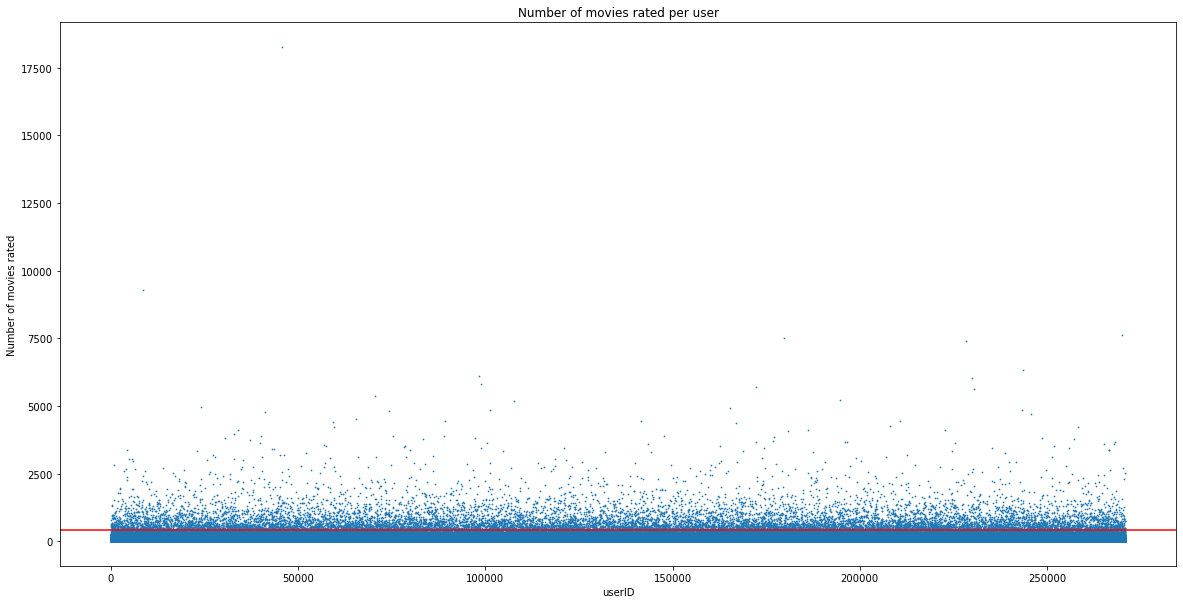

In [11]:
# Plot the ratings distributions
user = movies_rated.keys()
rating_num = movies_rated.values()
plt.figure(figsize=(20,10))
plt.scatter(user, rating_num, s=0.5)
plt.axhline(y=400, color='r')
plt.xlabel('userID')
plt.ylabel('Number of movies rated')
plt.title('Number of movies rated per user')
plt.show

In [12]:
len(user)

270896

The majority of users rated between 0 and 1250 movies. The graph shows a dense area of users rating between 0 and approximately 400 movies (indicated by the red line). 

<function matplotlib.pyplot.show(close=None, block=None)>

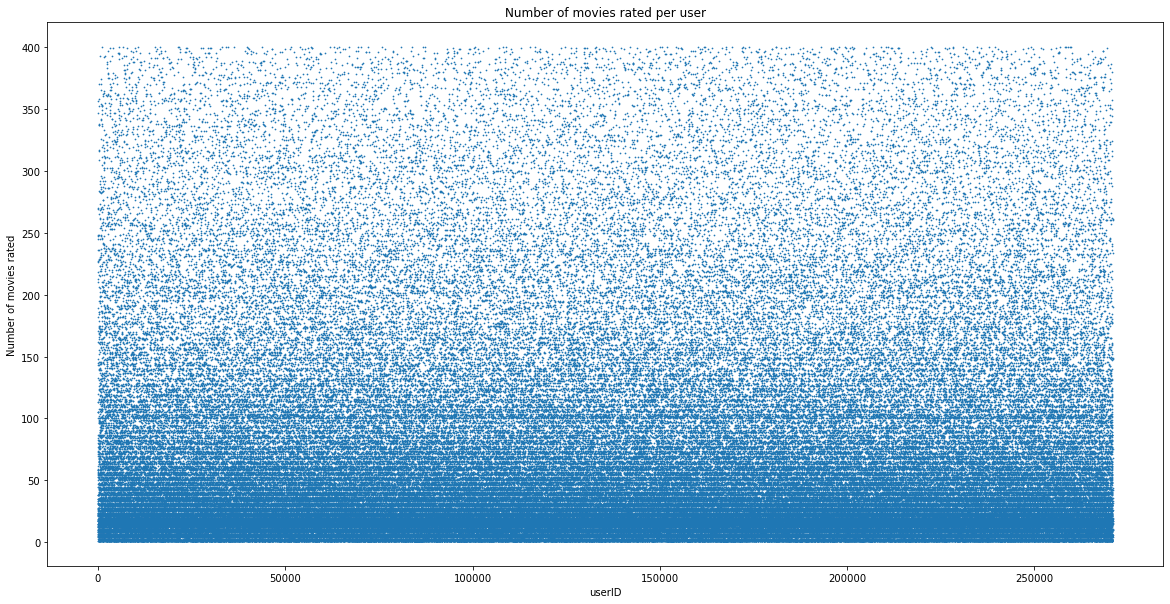

In [13]:
user_zoom = []
rating_num_zoom = []
[user_zoom.append(user) for user in user if movies_rated[user] <= 400]
[rating_num_zoom.append(movies_rated[user_zoom[i]]) for i in range(len(user_zoom))] 
plt.figure(figsize=(20,10))
plt.scatter(user_zoom, rating_num_zoom, s=0.5)
plt.xlabel('userID')
plt.ylabel('Number of movies rated')
plt.title('Number of movies rated per user')
plt.show

In [14]:
len(user_zoom)

257518

Users that rated between 0 and 400 movies represent a very large portion of the dataset, with users that rated between 0 and 25 movies still making up nearly half of the users in the dataset.

In [15]:
less_than_25 = []
[less_than_25.append(user) for user in movies_rated if movies_rated[user] <= 25]
len(less_than_25)

124916

In [16]:
# Number of ratings per movie
movieID = md['id']
vote_count = md['vote_count']
vote_average = md['vote_average']

In [17]:
# Genre distributions
md['genres'].head()

0    [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1    [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2    [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
3    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
4                       [{'id': 35, 'name': 'Comedy'}]
Name: genres, dtype: object

In [18]:
from ast import literal_eval
md['genres'] = md['genres'].apply(literal_eval)

In [19]:
genre_list = []
for genre in md['genres']:
    genres = [d['name'] for d in genre]
    if genre == md['genres'][0]:
        genre_list = genres
    else:
        genre_list = genre_list + genres

In [20]:
genre_distrb = dict(Counter(genre_list))

<BarContainer object of 20 artists>

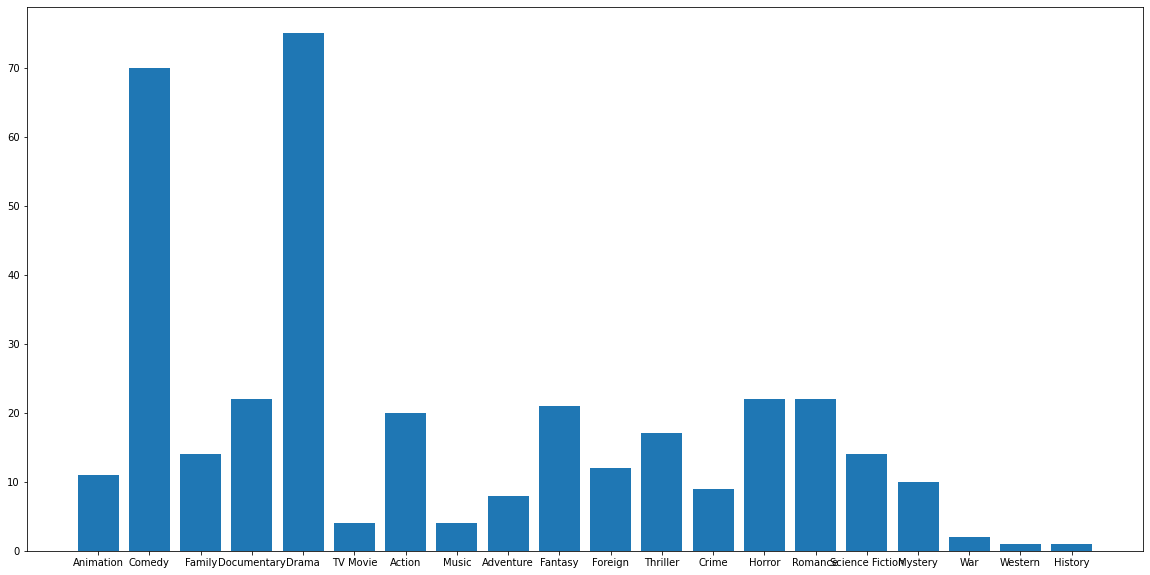

In [21]:
genre_names = genre_distrb.keys()
genre_counts = genre_distrb.values()
plt.figure(figsize=(20,10))
plt.bar(genre_names, genre_counts)

From an overview of the genre distribution we can see that whilst the other genres are fairly evenly distributed, there is a clear trend of comedy and drama within the dataset.

### Merging data and Pre-processing

In [22]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string

lemmatizer = WordNetLemmatizer()

def tokenize(text):
    return word_tokenize(text)

def lemmatize(words):
    words = [lemmatizer.lemmatize(word) for word in words]
    return words
    
# Lower casing
def lower(text):
    low_text = text.lower()
    return low_text

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

# Number removal
def remove_num(text):
    remove = re.sub(r'[^a-zA-Z ]', '' ,text)
    return remove

def remove_space(text):
    remove = text.replace(r'( +)'," ")
    return remove.strip()
    

# punctuation_removal
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

# convert a list into string
def list_str(lst):
    return ' '.join([str(item) for item in lst])

In [23]:
md['tagline'] = md['tagline'].fillna('')
md['overview'] = md['overview'].fillna('')
md['general'] = md['overview'] + md['tagline']

In [24]:
md['general'] = md['general'].apply(lambda x: remove_html(x))
md['general'] = md['general'].apply(lambda x: remove_num(x))
md['general'] = md['general'].apply(lambda x: remove_space(x))
md['general'] = md['general'].apply(lambda x: punctuation_removal(x))
md['general'] = md['general'].apply(lambda x: lower(x))
md['general'] = md['general'].apply(lambda x: tokenize(x))
md['general'] = md['general'].apply(lambda x: lemmatize(x))
md['general'] = md['general'].apply(lambda x: list_str(x))

In [25]:
md['general'] = [string.split(" ") for string in md['general']]

In [26]:
md['general'][0]

['led',
 'by',
 'woody',
 'andys',
 'toy',
 'live',
 'happily',
 'in',
 'his',
 'room',
 'until',
 'andys',
 'birthday',
 'brings',
 'buzz',
 'lightyear',
 'onto',
 'the',
 'scene',
 'afraid',
 'of',
 'losing',
 'his',
 'place',
 'in',
 'andys',
 'heart',
 'woody',
 'plot',
 'against',
 'buzz',
 'but',
 'when',
 'circumstance',
 'separate',
 'buzz',
 'and',
 'woody',
 'from',
 'their',
 'owner',
 'the',
 'duo',
 'eventually',
 'learns',
 'to',
 'put',
 'aside',
 'their',
 'difference']

In [27]:
keywords = pd.read_csv('data/keywords.csv')
credits = pd.read_csv('data/credits.csv')

In [28]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')

In [29]:
# merge the credits and keywords to md by 'id'
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [30]:
# only keep the movies which are also in links 
md = md[md['id'].isin(links)]
md.shape

(46628, 28)

In [31]:
from ast import literal_eval
md['cast'] = md['cast'].apply(literal_eval)
md['crew'] = md['crew'].apply(literal_eval)
md['keywords'] = md['keywords'].apply(literal_eval)

In [32]:
# To check what jobs inside of the crew
for i in md['crew'][1]:
    print(i['job'],end=' ')

Executive Producer Screenplay Original Music Composer Director Editor Casting Animation Supervisor Production Design Producer Executive Producer Executive Producer Director of Photography Novel Producer Screenplay Screenplay 

1. In the crew, we assume that most users concern about the Director and Screenplay, so we would like to keep director and screenplay in the crew. To expand the weight of director and screeplay, we will multiply the director'name by 5 and screenplay'name by 3. 

2. For cast, we want to keep the first five actors or actresses since they are the primary characters. 

3. We store the keywords of a movie in a list

In [33]:
import numpy as np
def get_director(crew):
    for c in crew:
        if c['job'] == 'Director':
            return [c['name']] * 5
    return np.nan

def get_screenplay(crew):
    for c in crew:
        if c['job'] == 'Screenplay':
            return [c['name']] * 3
    return np.nan

def get_five_actors(cast):
    l = []
    for c in cast:
        l.append(c['name'])
    return l[:5]

def get_genres(genres):
    l = []
    for g in genres:
        l.append(g['name'])
    return l

In [34]:
md['director'] = md['crew'].apply(get_director)
md['screenplay'] = md['crew'].apply(get_screenplay)
md['cast'] = md['cast'].apply(get_five_actors)
md['keywords'] = md['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
md['genres'] = md['genres'].apply(get_genres)

In [35]:
md['meta'] = md['director'] + md['screenplay'] + md ['cast'] + md['keywords'] + md['genres'] + md['general']

In [36]:
# Save pre-processed dataset
md.to_csv('data/movies_preprocessed.csv')

## Train a Word2Vec model on the Movies Metadata

After preprocessing the dataset, we produced a new dataset with a 'meta' column that combined all the metadata for each movie into one set of tokens. Using the metadata, we trained a Word2Vec model.

In [37]:
# Load pre-processed dataset
movies_data = pd.read_csv('data/movies_preprocessed.csv')

In [38]:
movies_data['meta'][0]

"['John Lasseter', 'John Lasseter', 'John Lasseter', 'John Lasseter', 'John Lasseter', 'Joss Whedon', 'Joss Whedon', 'Joss Whedon', 'Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim Varney', 'Wallace Shawn', 'jealousy', 'toy', 'boy', 'friendship', 'friends', 'rivalry', 'boy next door', 'new toy', 'toy comes to life', 'Animation', 'Comedy', 'Family', 'led', 'by', 'woody', 'andys', 'toy', 'live', 'happily', 'in', 'his', 'room', 'until', 'andys', 'birthday', 'brings', 'buzz', 'lightyear', 'onto', 'the', 'scene', 'afraid', 'of', 'losing', 'his', 'place', 'in', 'andys', 'heart', 'woody', 'plot', 'against', 'buzz', 'but', 'when', 'circumstance', 'separate', 'buzz', 'and', 'woody', 'from', 'their', 'owner', 'the', 'duo', 'eventually', 'learns', 'to', 'put', 'aside', 'their', 'difference']"

In [39]:
metadata = movies_data['meta']
metadata.isna().sum()

30603

In [40]:
metadata = metadata.dropna()

In [41]:
metadata.isna().sum()

0

In [42]:
metadata = metadata.apply(literal_eval)

In [43]:
sentences = [tokenlst for tokenlst in metadata]

In [44]:
# Build a Word2Vec model based on the movies metadata

import gensim.models

movie_model = gensim.models.Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)

In [45]:
movie_model.wv.most_similar(['long'], topn=5)

[('few', 0.9533368349075317),
 ('good', 0.9500011205673218),
 ('week', 0.9485450983047485),
 ('just', 0.9472877383232117),
 ('hour', 0.9462599158287048)]

In [46]:
# I actually feel like Doc2Vec makes more sense here (also easier lol)

In [47]:
# Yeee I built a model!

In [50]:
# Consider dropping movies that aren't in the Word2Vec vocab (i.e. movies not in movies_data)
drop_rows = []
for movie in ratings['movieId']:
    if movie not in movies_data['id']:
        index = ratings.index[movie]
        drop_rows.append(index)    

In [51]:
ratings = ratings.drop(drop_rows).reset_index()

In [53]:
ratings.head()

,index,userId,movieId,rating,timestamp
0,0,1,110,1.0,1425941529
1,1,1,147,4.5,1425942435
2,2,1,858,5.0,1425941523
3,3,1,1221,5.0,1425941546
4,4,1,1246,5.0,1425941556


In [55]:
# Collate the watch history of each user into a dictionary

watch_history = {}

for i in range(len(ratings['userId'])):
    if ratings['userId'][i] in watch_history.keys():
        watch_history[ratings['userId'][i]].append(ratings['movieId'][i])
    else:
        watch_history[ratings['userId'][i]] = [ratings['movieId'][i]]
    

In [57]:
len(watch_history)

270890

In [97]:
# After training a Doc2Vec model on the movie metadata
# function takes the user id - accesses watch history for that user id 
# for each movie gets its Doc2Vec and averages over the Doc2Vecs per movie
# then use infer vector (i think to get the most similar Docs to that docvec from the vocab)
# outputs the top n recommendations

In [104]:
# Train Doc2Vec model on metadata
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

documents = [TaggedDocument(sentences[i], tags = [movies_data['id'][metadata['index'][i]]]) for i in range(len(metadata))]

In [105]:
movie_recs = Doc2Vec(documents=documents, seed= 7, workers = 1) 

In [111]:
def get_recommendations_d2v(user, topn, )

array([ 0.31357288, -0.09256499, -0.058537  ,  0.31050158, -0.19653451,
       -0.14147213,  0.00512815,  0.11725084,  0.16904682, -0.08224773,
        0.01489902,  0.0495593 ,  0.0777007 ,  0.02153767,  0.05854017,
        0.06728242,  0.09541928, -0.04470647,  0.11220057, -0.12149991,
        0.00558168,  0.31100026,  0.01970292, -0.092636  , -0.03135632,
        0.15126081,  0.05165943, -0.35703456, -0.19124736, -0.07029571,
       -0.06488992, -0.12489773, -0.05393478,  0.00381542, -0.02067986,
        0.04458549, -0.01891763, -0.16767804,  0.00093312, -0.10987327,
        0.01137117, -0.04882138, -0.05322053, -0.07584545,  0.04913646,
        0.13324817,  0.1548875 ,  0.11456633, -0.03444919, -0.00055994,
       -0.05143727,  0.03021005,  0.00145922,  0.02715586,  0.09734525,
       -0.00917454,  0.0935923 ,  0.20377591,  0.13696629, -0.06290109,
        0.05668014,  0.04616301, -0.19199531, -0.07224955,  0.18247141,
       -0.03915398,  0.0521993 , -0.16244361, -0.26097736,  0.01

In [ ]:
# Finish later...